In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt

#sys.path.insert(0, '/media/abdulla/Seagate Expansion Drive/DVS research/DATA/contact estimation/')
from EventPreProcess import EventPreProcess
from dvs_msgs.msg import EventArray
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
#parameters of processing
frequency = 10 #Hz
bag_file_name = 'tactile_sensing_data/17_point_prediction_centered.bag'
h5_file_name = '17_point_centered.hdf5'
time_window_size = 40
examples_per_edge = 1

In [3]:
bag_file = rosbag.Bag(bag_file_name)

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

#generate labels
possible_angle = [0.1, 0.25]
N_examples = 9
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(list_of_rotations)


[[0, 0, 0], [0.07071067811865477, 0.07071067811865475, 0], [0.1767766952966369, 0.17677669529663687, 0], [6.123233995736766e-18, 0.1, 0], [1.5308084989341915e-17, 0.25, 0], [-0.07071067811865475, 0.07071067811865477, 0], [-0.17677669529663687, 0.1767766952966369, 0], [-0.1, 1.2246467991473533e-17, 0], [-0.25, 3.061616997868383e-17, 0], [-0.07071067811865477, -0.07071067811865475, 0], [-0.17677669529663692, -0.17677669529663687, 0], [-1.8369701987210297e-17, -0.1, 0], [-4.592425496802574e-17, -0.25, 0], [0.07071067811865474, -0.07071067811865477, 0], [0.17677669529663684, -0.17677669529663692, 0], [0.1, -2.4492935982947065e-17, 0], [0.25, -6.123233995736766e-17, 0]]


In [4]:
#parse rosbag

for topic, msg, t in bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle']):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())

In [5]:
#interpolate
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = range(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

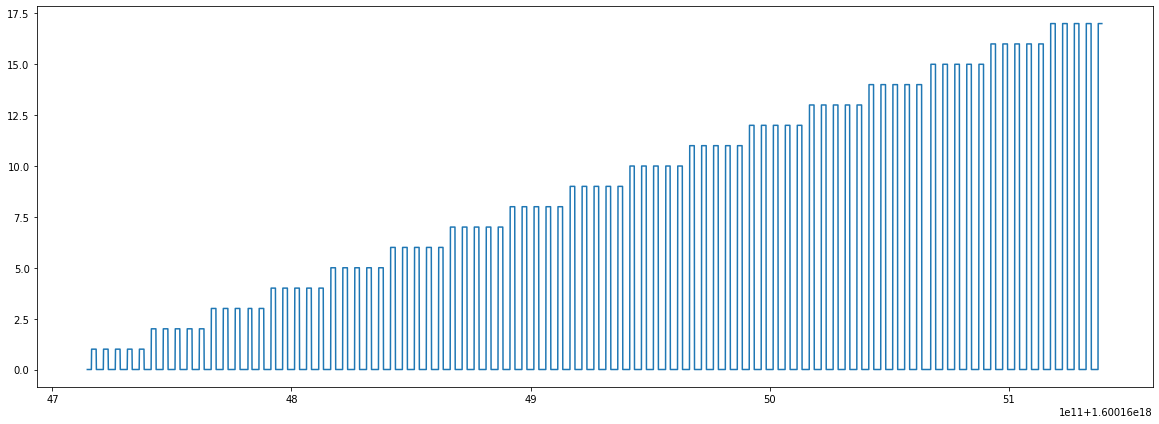

4245


In [6]:
plt.figure(figsize=(20,7))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [7]:
#Generate frames, crop and and store in h5 file
hf = h5py.File(h5_file_name, 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 1000
unprocessed_events = np.copy(events)

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])

    #[event_frames, unprocessed_events] = EventPreProcess.ConcatenateEvents(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    [event_frames, unprocessed_events] = EventPreProcess.generateFrames(unprocessed_events, contact_case_ts_int[start_idx:end_idx])

    cropped_image = EventPreProcess.cropFrames(event_frames, circle_center=(170, 125), circle_rad=115)

    #write data
    if i==0:
        print(np.shape(event_frames))
        hf.create_dataset('event_images', data=cropped_image, maxshape=(None,None, None, None))
    else:
        hf['event_images'].resize(len(hf['event_images']) + len(cropped_image), axis=0)
        hf["event_images"][-len(cropped_image):] = cropped_image
    del event_frames

hf.close()

1
Percentage finished: 58.07167566804335
Percentage finished: 58.08244202054432
Percentage finished: 58.091796392389426
Percentage finished: 58.10256274489039
Percentage finished: 58.11200536552649
Percentage finished: 58.12153623495358
Percentage finished: 58.17686822690529
Percentage finished: 59.10701048395637
Percentage finished: 59.62900208267147
Percentage finished: 59.996734794733314
Percentage finished: 60.094337957569984
Percentage finished: 60.13263793286032
Percentage finished: 60.16696671255604
Percentage finished: 60.18902891030393
Percentage finished: 60.20579618059232
Percentage finished: 60.22212220692577
Percentage finished: 60.2374774965583
Percentage finished: 60.25398002047372
Percentage finished: 60.266070104839564
Percentage finished: 60.277365950086484
Percentage finished: 60.28839704896043
Percentage finished: 60.29819266476049
Percentage finished: 60.30834127572452
Percentage finished: 60.31610716933178
Percentage finished: 60.32466730205796
Percentage finished

In [8]:
#Augment images with rotation
hf = h5py.File(h5_file_name, 'r+')
set_size = 1000

for i in range(0, len(hf['event_images']), set_size):
    start_idx=i
    end_idx=min([len(hf['event_images']), i+set_size])

    original_image = hf['event_images'][start_idx:end_idx]
    original_contact_status = hf['contact_status'][start_idx:end_idx]

    rot_90_image = EventPreProcess.rotateFrames(original_image, circle_center=(170, 125), rotate_angle=90)
    rot_90_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 90)

    rot_180_image = EventPreProcess.rotateFrames(original_image, circle_center=(170, 125), rotate_angle=180)
    rot_180_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 180)

    rot_270_image = EventPreProcess.rotateFrames(original_image, circle_center=(170, 125), rotate_angle=270)
    rot_270_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 270)


    #write data
    if i==0:
        hf.create_dataset('event_images_augmented', data=np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0), maxshape=(None,None, None, None))
        hf.create_dataset('contact_status_augmented', data=np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0), maxshape=(None,))
    else:
        hf['event_images_augmented'].resize(len(hf['event_images_augmented']) + 4*len(original_image), axis=0)
        hf["event_images_augmented"][-4*len(original_image):] = np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0)

        hf['contact_status_augmented'].resize(len(hf['contact_status_augmented']) + 4*len(original_contact_status), axis=0)
        hf["contact_status_augmented"][-4*len(original_contact_status):] = np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0)

hf.close()

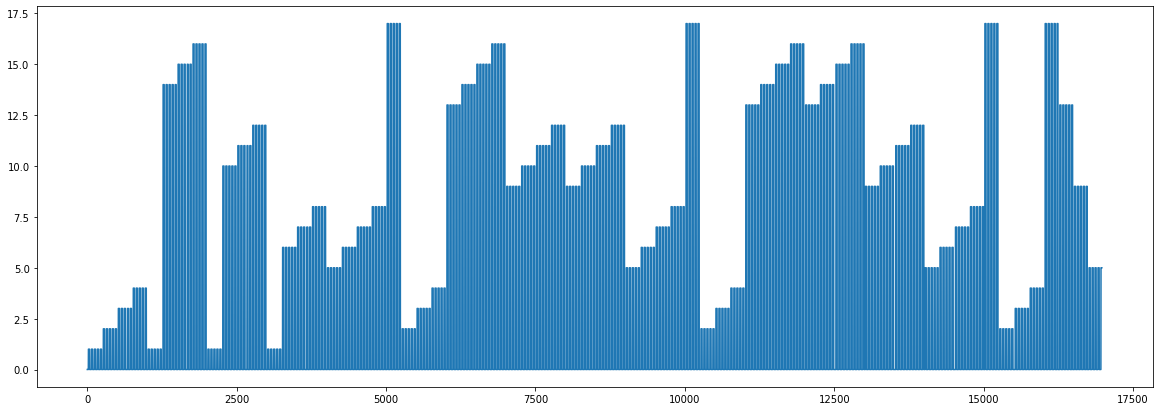

In [9]:
hf = h5py.File(h5_file_name, 'r')
plt.figure(figsize=(20,7))
plt.plot(hf["contact_status_augmented"])
plt.show()
hf.close()

In [55]:
print(np.array(list_of_rotations[2][0:2]))
rotation_angle = 90
rot_mat = np.array( [ [math.cos(rotation_angle*math.pi/180), math.sin(rotation_angle*math.pi/180)], [-math.sin(rotation_angle*math.pi/180), math.cos(rotation_angle*math.pi/180)] ] )
print(rot_mat)
print(np.matmul(rot_mat, list_of_rotations[2][0:2] ))

[0.1767767 0.1767767]
[[ 6.123234e-17  1.000000e+00]
 [-1.000000e+00  6.123234e-17]]
[ 0.1767767 -0.1767767]


In [10]:
hf = h5py.File(h5_file_name, 'r+')
print('number of event images: {}'.format(len(hf['contact_status_augmented'])))
hf.close()

number of event images: 16980


In [14]:
#Find rise/drop time and create windows accordingle
hf = h5py.File(h5_file_name, 'r+')
edge_locations = np.where(np.diff(hf['contact_status_augmented'])>0)
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)
hf.close()

#Divide the data set into windows

def extract_edge_data(hf_file, edge_index_list, n_examples_per_edge=examples_per_edge, window_size=time_window_size, n_classes=18):
    
    for i in range(len(edge_index_list)):
        index = edge_index_list[i]

        for j in range(n_examples_per_edge):
            if hf_file['contact_status_augmented'][index+1] == 0:
                #fall edge case
                start_index = max([0, math.floor(index+5)])
                end_index = start_index + window_size               
            else:
                #rise edge case
                start_index = max([0, math.floor(index-window_size*2/3)])
                end_index = start_index + window_size

            if end_index <= len(hf_file['contact_status_augmented']):
                reference_idx = range(int(start_index), int(end_index))
                one_hot_vector = [0] * n_classes
                one_hot_vector[int(hf_file['contact_status_augmented'][index+1])] = 1
                
                if not ('ex_input_image_idx' in hf_file.keys()):
                    hf_file.create_dataset('ex_input_image_idx', data=[reference_idx], maxshape=(None,None))
                    hf_file.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
                else:
                    hf_file['ex_input_image_idx'].resize(len(hf_file['ex_input_image_idx']) + 1, axis=0)
                    hf_file["ex_input_image_idx"][len(hf_file['ex_input_image_idx'])-1] = reference_idx

                    hf_file['ex_output'].resize(len(hf_file['ex_output']) + 1, axis=0)
                    hf_file["ex_output"][len(hf_file['ex_output'])-1] = one_hot_vector

[17, 67, 117, 167, 217, 267, 317, 367, 417, 468, 518, 568, 618, 672, 718, 768, 817, 867, 917, 968, 1017, 1067, 1117, 1167, 1217, 1267, 1317, 1367, 1417, 1468, 1518, 1568, 1618, 1672, 1718, 1768, 1817, 1867, 1917, 1968, 2017, 2067, 2117, 2167, 2217, 2267, 2317, 2367, 2417, 2468, 2518, 2568, 2618, 2672, 2718, 2768, 2817, 2867, 2917, 2968, 3017, 3067, 3117, 3167, 3217, 3267, 3317, 3367, 3417, 3468, 3518, 3568, 3618, 3672, 3718, 3768, 3817, 3867, 3917, 3968, 4018, 4068, 4118, 4168, 4218, 4268, 4318, 4368, 4418, 4469, 4518, 4568, 4618, 4668, 4718, 4768, 4818, 4868, 4918, 4968, 5018, 5068, 5118, 5168, 5218, 5268, 5318, 5368, 5418, 5469, 5518, 5568, 5618, 5668, 5718, 5768, 5818, 5868, 5918, 5968, 6018, 6068, 6118, 6168, 6218, 6268, 6318, 6368, 6418, 6469, 6518, 6568, 6618, 6668, 6718, 6768, 6818, 6868, 6918, 6968, 7018, 7068, 7118, 7168, 7218, 7268, 7318, 7368, 7418, 7469, 7518, 7568, 7618, 7668, 7718, 7768, 7818, 7868, 7918, 7968, 8019, 8069, 8119, 8169, 8219, 8269, 8318, 8368, 8419, 8469, 8

In [12]:
#Divide the data set into windows

def create_dataset(hf_file, time_steps=50, n_classes=18):
    for i in range(time_steps, len(hf_file['event_images_augmented']) - time_steps):
        if (i%1000) == 0:
            print(i/float(len(hf_file['event_images_augmented'])))
        reference_idx = range(i-time_steps+1,i+1)
        one_hot_vector = [0] * n_classes
        one_hot_vector[int(hf_file['contact_status_augmented'][i])] = 1
        
        if i==time_steps:
            hf_file.create_dataset('ex_input_image_idx', data=[reference_idx], maxshape=(None,None))
            hf_file.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
        else:
            hf_file['ex_input_image_idx'].resize(len(hf_file['ex_input_image_idx']) + 1, axis=0)
            hf_file["ex_input_image_idx"][len(hf_file['ex_input_image_idx'])-1] = reference_idx

            hf_file['ex_output'].resize(len(hf_file['ex_output']) + 1, axis=0)
            hf_file["ex_output"][len(hf_file['ex_output'])-1] = one_hot_vector

In [15]:
hf = h5py.File(h5_file_name, 'r+')
extract_edge_data(hf, edge_locations)
hf.close()

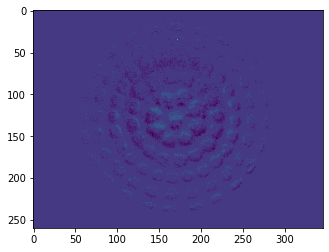

In [21]:
#Visualize events at switching states
hf = h5py.File(h5_file_name, 'r+')
indx = 95
plt.imshow(hf['event_images_augmented'][edge_locations[indx]][:,:,0])
plt.show
hf.close()

[0, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


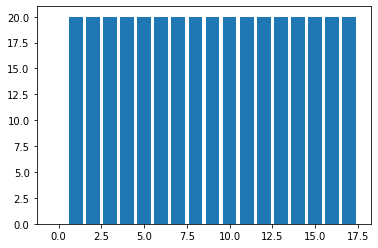

In [22]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['ex_output'])):
    idx = list(hf['ex_output'][i]).index(1)
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,18),counter)
hf.close()

In [23]:
#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(1, len(hf_file['ex_output'])):
        idx = list(hf['ex_output'][i]).index(1)
        
        if (np.random.rand() < (float(min(counter[1:])) / counter[idx])):
            if 'ex_input_image_idx_equalized' in hf_file.keys():
                hf_file['ex_input_image_idx_equalized'].resize(len(hf_file['ex_input_image_idx_equalized']) + 1, axis=0)
                hf_file["ex_input_image_idx_equalized"][len(hf_file['ex_input_image_idx_equalized'])-1] = hf_file['ex_input_image_idx'][i]

                hf_file['ex_output_equalized'].resize(len(hf_file['ex_output_equalized']) + 1, axis=0)
                hf_file["ex_output_equalized"][len(hf_file['ex_output_equalized'])-1] = hf['ex_output'][i]
            else:
                hf_file.create_dataset('ex_input_image_idx_equalized', data=[hf_file['ex_input_image_idx'][i]], maxshape=(None,None))
                hf_file.create_dataset('ex_output_equalized', data=[hf_file['ex_output'][i]], maxshape=(None, None))

equalize_representation(hf, counter)

[0, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


<BarContainer object of 18 artists>

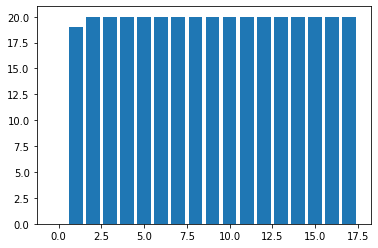

In [24]:
new_counter = [0] * 18

for i in range(len(hf['ex_output_equalized'])):
    idx = list(hf['ex_output_equalized'][i]).index(1)
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)

In [25]:
print(len(hf['ex_output_equalized']))

339


In [20]:
hf.close()

In [30]:
hf = h5py.File(h5_file_name, 'r+')
del hf['ex_input_image_idx'] 
del hf['ex_output']
hf.close()

KeyError: "Couldn't delete link (callback link pointer is NULL (specified link may be '.' or not exist))"

In [33]:
print(np.mean(hf['event_images'][:,:,:,0]))
print(np.std(hf['event_images'][:,:,:,0]))
print(np.max(hf['event_images'][:,:,:,0]))
print(np.min(hf['event_images'][:,:,:,0]))


0.0008835273
0.031460017
21.0
0.0
